In [1]:
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

In [2]:
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)

In [3]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k_neighbors=5, p=2, weighted='q'):
        self.k_neighbors = k_neighbors
        self.p = p
        self.weighted = weighted
        self.y = None
        self.X = None

    def __calculate_weight(self, distance, q=0.5):
        if self.weighted == 'q':
            return np.power(q, distance)
        elif self.weighted == 'a':
            return 1 / (distance + 1e-15)
        else:
            return 1.

    def fit(self, X, y=None):
        self.X = X.copy()
        self.y = y.copy()
        return self

    def __calc_distance(self, a, b):
        return np.linalg.norm(a-b, ord=self.p)

    def predict(self, X):
        answers = []
        for x in X:
            test_distances = []
            
            for i in range(X.shape[0]):
                distance = self.__calc_distance(x, self.X[i])
                test_distances.append((distance, self.y[i]))
            
            weights, classes = [], []
            for d in sorted(test_distances)[:self.k_neighbors]:
                weights.append(self.__calculate_weight(d[0]))
                classes.append(d[1])

            answers.append(np.argmax(np.bincount(classes, weights=weights)))
        return answers

In [4]:
pipe = make_pipeline(StandardScaler(), KNNClassifier(k_neighbors=5, weighted='q'))

pipe.fit(X_train, y_train)
train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

print(classification_report(y_train, train_pred, digits=3))
print(classification_report(y_test, test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        35
           1      0.971     0.971     0.971        35
           2      0.971     0.971     0.971        35

    accuracy                          0.981       105
   macro avg      0.981     0.981     0.981       105
weighted avg      0.981     0.981     0.981       105

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        15
           1      0.933     0.933     0.933        15
           2      0.933     0.933     0.933        15

    accuracy                          0.956        45
   macro avg      0.956     0.956     0.956        45
weighted avg      0.956     0.956     0.956        45



In [5]:
pipe_sk = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', p=2))

pipe_sk.fit(X_train, y_train)
train_pred = pipe_sk.predict(X_train)
test_pred = pipe_sk.predict(X_test)

print(classification_report(y_train, train_pred, digits=3))
print(classification_report(y_test, test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        35
           1      1.000     1.000     1.000        35
           2      1.000     1.000     1.000        35

    accuracy                          1.000       105
   macro avg      1.000     1.000     1.000       105
weighted avg      1.000     1.000     1.000       105

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        15
           1      0.833     1.000     0.909        15
           2      1.000     0.800     0.889        15

    accuracy                          0.933        45
   macro avg      0.944     0.933     0.933        45
weighted avg      0.944     0.933     0.933        45



In [6]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=2000, random_state=seed)

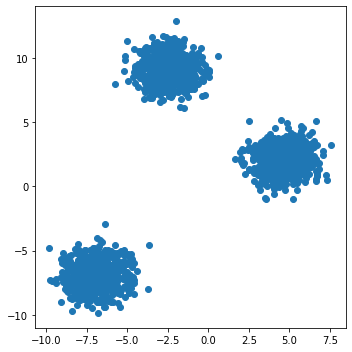

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

In [8]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='*', s=130, c='black')
        
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item], alpha=0.3)
            
    plt.show()

In [9]:
class KMeansNaive(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, n_init=2, max_iter=20, tol=1e-4, _labels=False, init='kmeans++'):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self._labels = _labels
        self.init = init

    @staticmethod
    def __calc_distance(a, b):
        return np.linalg.norm(a-b, ord=2)

    def fit(self, X, y=None):
        scores = []
        for _ in range(self.n_init):
            if self.init == 'random':
                indices = np.random.choice(X.shape[0], size=self.n_clusters)
                self.centroids = X[indices]
            elif self.init == 'kmeans++':
                self.centroids = self.init_kpp_centroids(X, k=self.n_clusters)
            else:
                raise ValueError(f'init should be "random" or "kmeans++", {self.init} given.')
    
            for _ in range(self.max_iter):
                classes = {i: [] for i in range(self.n_clusters)}
                for x in X:
                    distances = [self.__calc_distance(x, centroid) for centroid in self.centroids]
                    classification = distances.index(min(distances))
                    classes[classification].append(x)
        
                old_centroids = self.centroids.copy()
        
                for classification in classes:
                    self.centroids[classification] = np.average(classes[classification], axis=0)
                optimal = True
                for centroid in range(len(self.centroids)):
                    if np.sum(abs((self.centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > self.tol:
                        optimal = False
                if optimal:
                    #self.centroids = old_centroids.copy()
                    break
            score = self.__calculate_inner_distance_squared(old_centroids, classes)
            scores.append((old_centroids, score))
        self.centroids = min(scores, key=lambda x: x[1])[0]
        return self

    def predict(self, X):
        classes = {i: [] for i in range(self.n_clusters)} if not self._labels else np.zeros((X.shape[0],))
        for i, x in enumerate(X):
            distances = [self.__calc_distance(x, centroid) for centroid in self.centroids]
            classification = distances.index(min(distances))
            if self._labels:
                classes[i] = classification
            else:
                classes[classification].append(x)
        return classes

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)

    @staticmethod
    def __calculate_inner_distance_squared(centroids, classes):
        distances = np.zeros(len(centroids))
        result = 0
        for i, c in enumerate(centroids):
            for x in classes[i]:
                distances[i] += np.linalg.norm(c - x, ord=2)**2
            result += distances[i] / len(classes[i])
        return result

    def init_kpp_centroids(self, X, k=3):
        centroids = []
        idx = np.random.randint(X.shape[0]) # select random point for first centroid
        centroids.append(X[idx, :])

        for c_id in range(k-1):  # select other k-1 centroids
            distances = []
            for i in range(X.shape[0]):  # calculate distances from every data point to existing centroids
                point = X[i, :]
                d = np.inf
                for j in range(len(centroids)):
                    temp_dist = self.__calc_distance(point, centroids[j])
                    d = min(d, temp_dist)  # select the minimum distance to existing centroids
                distances.append(d)
            distances = np.array(distances)
            next_centroid = X[np.argmax(distances), :]  # the next centroid is data point with max dist to other cent.
            centroids.append(next_centroid)
        return np.array([list(c) for c in centroids])

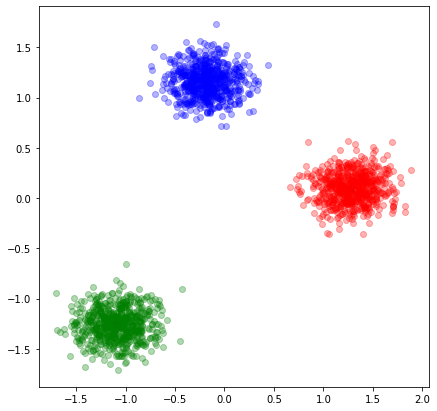

In [10]:
k_means = make_pipeline(StandardScaler(), KMeansNaive())  # KMeansNaive is numerically unstable! because of average
k_means.fit(X)
classes = k_means.predict(X)

visualize(k_means[-1].centroids, classes)

среднее квадратичное внутрикластерное расстояние:

$$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

In [11]:
def calculate_inner_distance_squared(centroids, classes):
    distances = np.zeros(len(centroids))
    result = 0
    for i, c in enumerate(centroids):
        for x in classes[i]:
            distances[i] += np.linalg.norm(c - x, ord=2)**2
        result += distances[i] / len(classes[i])
    return result

In [12]:
calculate_inner_distance_squared(k_means[-1].centroids, classes)

0.19394384400322467

In [13]:
results = []

for k in range(1, 11):
    km = make_pipeline(StandardScaler(), KMeansNaive(n_clusters=k))
    classes = km.fit_predict(X)
    results.append(calculate_inner_distance_squared(km[-1].centroids, classes))

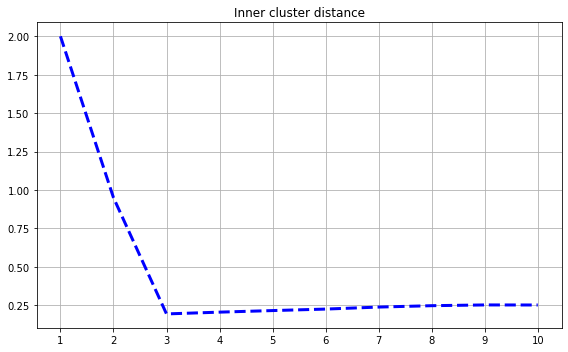

In [14]:
plt.figure(figsize=(8,5))
plt.title('Inner cluster distance')
plt.plot(np.arange(1,11), results, lw=3, ls='--', c='blue')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(1,11))
plt.show()
# Elbow, best n_clusters = 3

#### Лучшее количество кластеров = 3

For n_clusters = 2 The average silhouette_score is : 0.7070259837794035
For n_clusters = 3 The average silhouette_score is : 0.8417142141078933
For n_clusters = 4 The average silhouette_score is : 0.6701152646301904
For n_clusters = 5 The average silhouette_score is : 0.6709023999496776
For n_clusters = 6 The average silhouette_score is : 0.6543296713075026


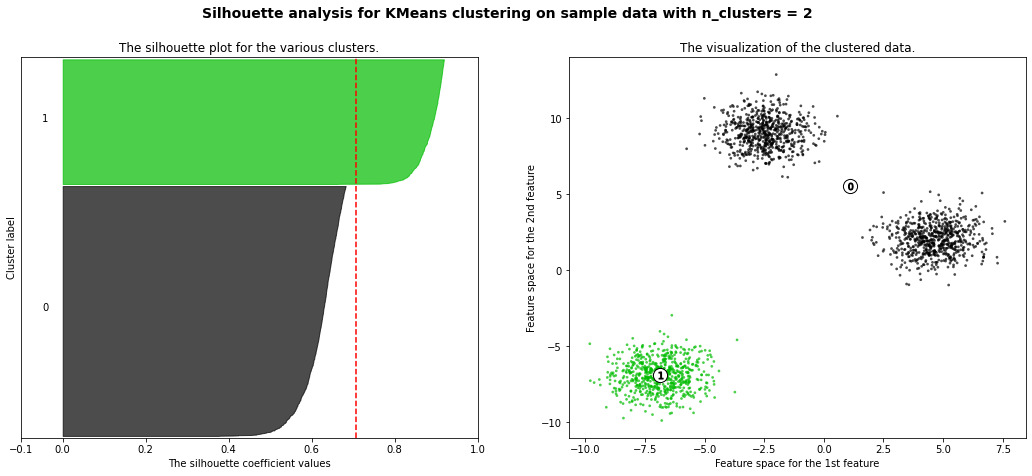

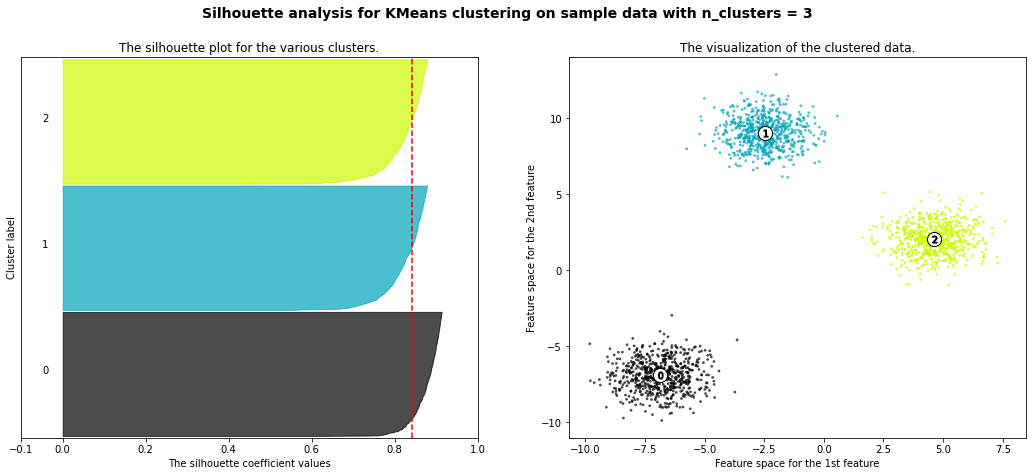

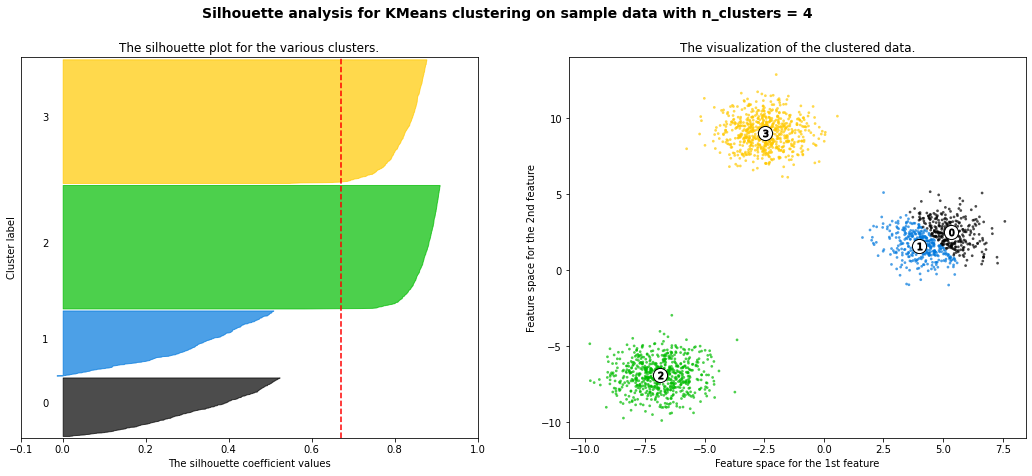

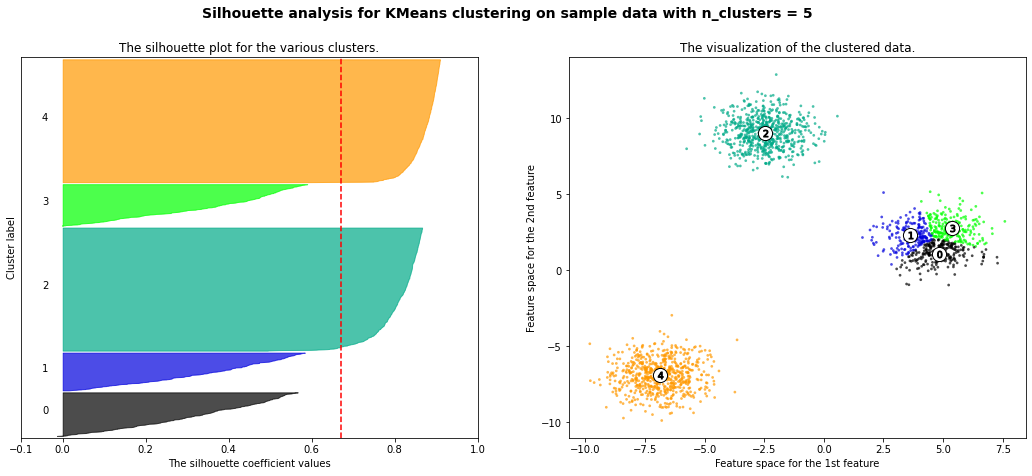

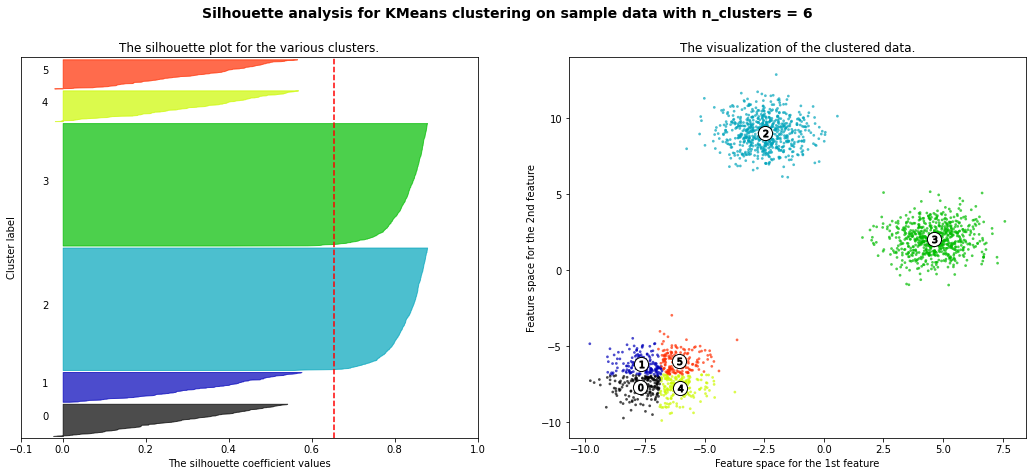

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeansNaive(n_clusters=n_clusters, _labels=True, init='random')
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.centroids
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Из приведеноной визуализации следует, что наилучшее количество кластеров = 3.